# Imports

(für ein virtuelles environment (unix)):
```bash
python -m venv .venv
source .venv/bin/activate
```

Siehe `requirements.txt` für alle benötigten Module. Um diese zu installieren, folgendes ausführen (gerne in einem virtual environment):

```bash
pip install -r requirements.txt
```

Nicht wundern, wieso die File so ausführlich ist. Die Datei ist lediglich das Resultat von `pip freeze > requirements.txt`.

In [1]:
import pandas as pd
import numpy as np
import os
import re

# Sklearn für Split, Preprocessing und Metriken
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Keras für das Modell
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

2025-07-08 18:18:09.224180: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-08 18:18:09.409039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751991489.476151     989 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751991489.496768     989 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751991489.645658     989 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Helper Functions

Um den Code etwas sauberer zu halten und klare Trennungen einzubauen.

In [10]:
input_dir = r'/home/myrol/bachelors-python/bachelorarbeit/python/resources/fars'

# Ressourcen zu einem DataFrame kombinieren
def combine_resources():
    dfs = []

    for directory in os.listdir(input_dir):
        if re.match(r"\d{4}", directory) and directory != '2010':
            filepath = os.path.join(input_dir, directory, 'accident.csv')

            df = pd.read_csv(
                filepath,
                encoding='latin-1',
                dtype={'STATE': 'Int64'}
            ) 
            dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

# Einige Attribute der `df` zyklisch zu encoden
def cyclic_encoding(df):
    df['SIN_WEEK'] = np.sin(df['WEEK'] / 52 * 2 * np.pi)
    df['COS_WEEK'] = np.cos(df['WEEK'] / 52 * 2 * np.pi)

    return df

# DataFrame gruppieren und aggregieren
def aggregate(df):
    # Kalenderwoche bauen aus datetime
    df['WEEK'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']]).dt.isocalendar().week - 1

    global categoric_columns
    categoric_columns = ["WEATHER", "MAN_COLL", "LGT_COND", "HARM_EV"]
    numeric_aggregation_strategies = {
        'FATALS': 'sum',
        'VE_TOTAL': 'sum',
        'PERSONS': 'sum',
        'PERNOTMVIT': 'sum'
    }

    # Strategie zum aggregieren einer Spalte. Hier wird lediglich der Modus berechnet.
    mode = lambda x: x.mode().iloc[0]

    # Vorher festgelegte Strategien ergänzen
    aggregation_strategies_dict = {**numeric_aggregation_strategies}
    for c in categoric_columns:
        aggregation_strategies_dict[c] = mode


    # Gruppierung und Aggregation
    df = (
        df
        .groupby(['STATE', 'WEEK', 'YEAR'])
        .agg(aggregation_strategies_dict)
        .reset_index()
    )

    return df

# Datensatz für das Modell splitten
def split(df, features_numeric, features_categoric, target):
    # Drop Zeilen mit Missing Values in den gewählten Spalten
    df = df.dropna(subset=features_numeric + features_categoric + [target])

    # Trennung der Spalten und numerisch und kategorisch für den OHE (siehe unten)
    X_numeric = df[features_numeric]
    X_categoric = df[features_categoric]
    y = df[target]

    # One-Hot Encoding (OHE) für Kategorien
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    X_categoric_encoded = ohe.fit_transform(X_categoric)
    categoric_names  = ohe.get_feature_names_out(features_categoric)
    X_categoric_encoded = pd.DataFrame(X_categoric_encoded, columns=categoric_names, index=df.index)

    # Zusammenführen + Train/Test Split
    X = pd.concat([X_numeric, X_categoric_encoded], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    # Skalierung numerischer Features
    scaler = StandardScaler()
    X_train[features_numeric] = scaler.fit_transform(X_train[features_numeric])
    X_test[features_numeric]  = scaler.transform(X_test[features_numeric])

    return X_train, X_test, y_train, y_test

# Hauptteil

Hier werden alle Helper-Functions aufgerufen und das Modell trainiert. Funktioniert gut mit einer GPU.

In [11]:
# DataFrame vorbereiten
df = combine_resources()
df = aggregate(df)
df = cyclic_encoding(df)

# Features isolieren
features_numeric = [
  "YEAR", "SIN_WEEK", "COS_WEEK", "VE_TOTAL", "PERSONS", "PERNOTMVIT"
]
features_categoric = categoric_columns + ['STATE']

# Ziel der Regression
target = "FATALS"

X_train, X_test, y_train, y_test = split(df, features_numeric, features_categoric, target)

# Keras-Modell definieren
model = Sequential([
    Dense(64, activation="tanh", input_shape=(X_train.shape[1],)),
    Dense(32, activation="tanh"),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

# Training mit Early Stopping
es = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# Performance-Evaluation
y_pred = model.predict(X_test).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"Test MSE : {mse:.3f}")
print(f"Test MAE : {mae:.3f} Todesopfer")
print(f"Test R²  : {r2:.3f}")

/tmp/ipykernel_989/52816707.py:11: DtypeWarning: Columns (40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/tmp/ipykernel_989/52816707.py:11: DtypeWarning: Columns (40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/home/myrol/bachelors-python/bachelorarbeit/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1751991884.732930     989 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9502 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/100


I0000 00:00:1751991885.952564   11593 service.cc:152] XLA service 0x708c640059f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751991885.952594   11593 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2025-07-08 18:24:45.977359: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751991886.063058   11593 cuda_dnn.cc:529] Loaded cuDNN version 90300


 83/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 336.4550 - mae: 11.6461

I0000 00:00:1751991886.881488   11593 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 264.6321 - mae: 8.5491 - val_loss: 139.0860 - val_mae: 4.2625
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 124.0226 - mae: 3.9460 - val_loss: 80.4440 - val_mae: 3.1355
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 69.0857 - mae: 2.9815 - val_loss: 46.2167 - val_mae: 2.5406
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 41.9346 - mae: 2.4666 - val_loss: 26.5335 - val_mae: 2.0615
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 22.9789 - mae: 1.9728 - val_loss: 16.1411 - val_mae: 1.7906
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 16.0754 - mae: 1.7763 - val_loss: 10.6857 - val_mae: 1.5991
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 10.2828 - mae: 1.5804 - val_loss: 7.9462 - val_mae: 1.5416
Epoch 8/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.2582 - mae: 1.4869 - val_loss: 6.5000 - val_mae: 1.4493
Epoch 9/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 

# Visualisierung der Ergebnisse

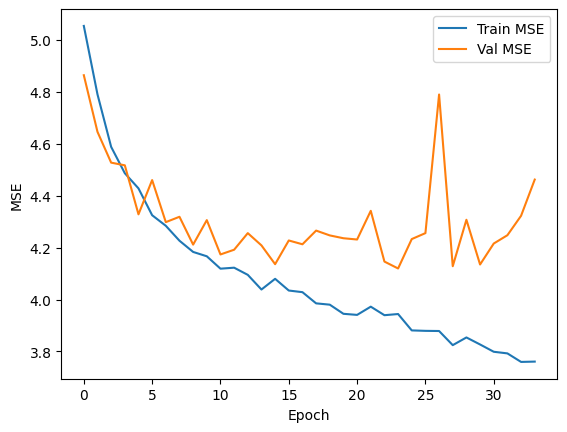

In [12]:
import matplotlib.pyplot as plt

# Die Werte am Anfang sind sehr groß, daher sieht man den Verlauf der Werte nicht so gut. Hiermit kann man den cut-off point bestimmen.
truncate_from = 10

plt.figure()
plt.plot(history.history["loss"][truncate_from:], label="Train MSE")
plt.plot(history.history["val_loss"][truncate_from:], label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

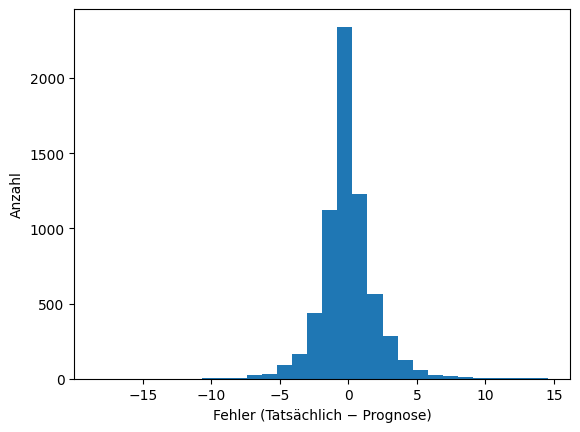

In [13]:
residuals = y_test - y_pred
plt.hist(residuals, bins=30)
plt.xlabel("Fehler (Tatsächlich − Prognose)")
plt.ylabel("Anzahl")
plt.show()

# Analyse der Datensätze

Das kann ignoriert werden. Das ist eher ein Spielplatz, um die Daten besser zu verstehen.
Aktuell wird hier lediglich analysiert, welche Spalten in welchen Jahren gegeben sind und in welchen nicht

In [ ]:
ls = sorted([x for x in os.listdir(input_dir) if bool(re.match(r"\d{4}", x))])

dfs = []
for directory in ls:
    if re.match(r"\d{4}", directory):
        df = pd.read_csv(os.path.join(input_dir, directory, 'accident.csv'), encoding='latin-1')
        dfs.append(df)

cols = []

for df in dfs:
    cols.append(list(df.columns))

years_start = 2010
years_end = 2023

liste_der_lists = [(f'{x}', cols[x - years_start]) for x in range(years_start, years_end+1)]

# Alle Spaltennamen aufsammeln
alle_spalten = set()
for name, cols in liste_der_lists:
    alle_spalten.update(cols)

# Für jede Spalte: in welchen Listen kommt sie vor?
from collections import defaultdict

spalten_in_listen = defaultdict(list)

for spalte in alle_spalten:
    for name, cols in liste_der_lists:
        if spalte in cols:
            spalten_in_listen[spalte].append(name)

# Übersicht ausgeben
for spalte in sorted(alle_spalten):
    if spalte not in features_categoric + features_numeric:
        continue
    vorhanden_in = spalten_in_listen[spalte]
    nicht_in = [name for name, _ in liste_der_lists if name not in vorhanden_in]
    print(f"Spalte: {spalte}")
    print(f"  ➔ vorhanden in: {vorhanden_in}")
    print(f"  ➔ fehlt in:     {nicht_in}\n")


/tmp/ipykernel_965/2899787341.py:40: DtypeWarning: Columns (40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(input_dir, directory, 'accident.csv'), encoding='latin-1')
/tmp/ipykernel_965/2899787341.py:40: DtypeWarning: Columns (40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(input_dir, directory, 'accident.csv'), encoding='latin-1')


Spalte: HARM_EV
  ➔ vorhanden in: ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
  ➔ fehlt in:     []

Spalte: LGT_COND
  ➔ vorhanden in: ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
  ➔ fehlt in:     []

Spalte: MAN_COLL
  ➔ vorhanden in: ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
  ➔ fehlt in:     []

Spalte: PERNOTMVIT
  ➔ vorhanden in: ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
  ➔ fehlt in:     ['2010']

Spalte: PERSONS
  ➔ vorhanden in: ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
  ➔ fehlt in:     []

Spalte: STATE
  ➔ vorhanden in: ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
  ➔ feh